In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nlp_processor import Processor 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [175]:
# Data Preperation

data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

cleaned_training_data = raw_training_data
cleaned_testing_data = raw_testing_data

training_texts = list(cleaned_training_data['Review'])
training_labels = list(cleaned_training_data['Sentiment'])  
test_texts = list(cleaned_testing_data['Review'])
test_labels = list(cleaned_testing_data['Sentiment'])

In [176]:
# Tokenize and prepare your data as before
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(training_texts)

train_sequences = tokenizer.texts_to_sequences(training_texts)
train_data = pad_sequences(train_sequences, maxlen=100)
train_labels = np.array(training_labels)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=100)
test_labels = np.array(test_labels)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6324 - loss: 0.6826 - val_accuracy: 0.0000e+00 - val_loss: 0.8752
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6120 - loss: 0.6411 - val_accuracy: 0.0045 - val_loss: 0.9868
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6792 - loss: 0.5424 - val_accuracy: 0.3288 - val_loss: 0.9492
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9111 - loss: 0.3626 - val_accuracy: 0.5586 - val_loss: 0.9680
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9531 - loss: 0.2180 - val_accuracy: 0.4459 - val_loss: 1.4782
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9744 - loss: 0.1398 - val_accuracy: 0.3874 - val_loss: 2.0412
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9747 - loss: 0.1153 - val_accuracy: 0.6577 - val_loss: 1.1935
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9859 - loss: 0.0717 - val_accuracy: 0.6171

,Predicted Negative,Predicted Positive
Actual Negative,61,77
Actual Positive,25,113


Accuracy:  0.63


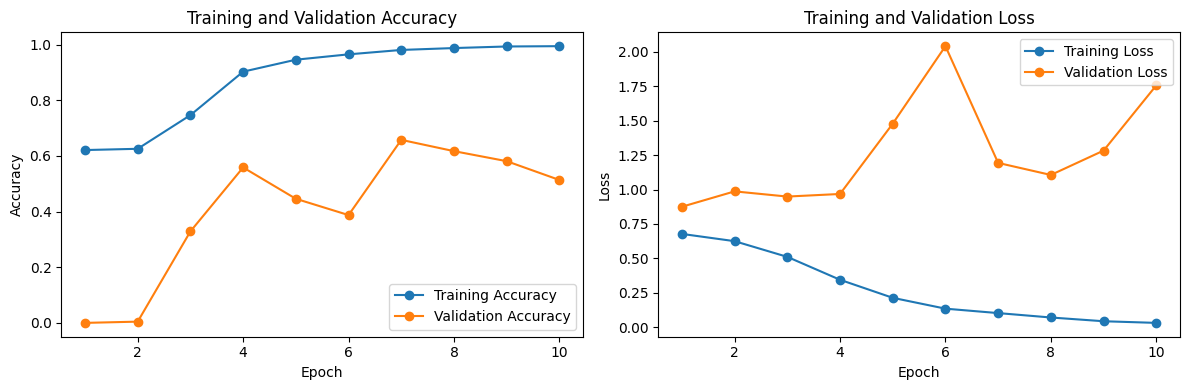

In [177]:
def model_run(embedding_dim, lstm_unit, dropout_rate, reg_strength):

    model = Sequential([
        Input(shape=(100,)),
        Embedding(input_dim=10000, output_dim=embedding_dim),
        LSTM(lstm_unit, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2)

    # Predicting on test data
    test_predictions_proba = model.predict(test_data)
    test_predictions = (test_predictions_proba > 0.5).astype("int32").flatten()
    
    # Generating and plotting confusion matrix
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    display(conf_matrix_df)

    accuracy = accuracy_score(test_labels, test_predictions)
    print('Accuracy: ', round(accuracy, 3))
    model_evaluation(history)


model_run(embedding_dim = 64, lstm_unit = 32, dropout_rate = 0.1, reg_strength = 0)

In [171]:
def grid_search(embedding_dims, lstm_units, dropout_rates, regularization_strengths):
        
    best_accuracy = 0
    best_config = {}
    best_history = None
    total_runs = len(embedding_dims) * len(lstm_units) * len(dropout_rates) * len(regularization_strengths)
    run = 0
    
    # Grid search
    for embedding_dim in embedding_dims:
        for lstm_unit in lstm_units:
            for dropout_rate in dropout_rates:
                for reg_strength in regularization_strengths:
                    run += 1
                    print(f"{run}/{total_runs}: Testing config: Embedding Dim {embedding_dim}, LSTM Units {lstm_unit}, Dropout {dropout_rate}, Reg Strength {reg_strength}")
                    
                    # Define model
                    model = Sequential([
                        Input(shape=(100,)),
                        Embedding(input_dim=10000, output_dim=embedding_dim),
                        LSTM(lstm_unit, dropout=dropout_rate, recurrent_dropout=dropout_rate),
                        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
                    ])
                    
                    # Compile model
                    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Train model
                    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                    history = model.fit(train_data, train_labels, batch_size=32, epochs=5, validation_split=0.2, callbacks=[early_stopping])
                    
                    # Evaluate model
                    _, accuracy = model.evaluate(test_data, test_labels, verbose=0)
                    
                    # Update best config if current config is better
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_history = history 
                        best_config = {
                            'embedding_dim': embedding_dim,
                            'lstm_unit': lstm_unit,
                            'dropout_rate': dropout_rate,
                            'reg_strength': reg_strength
                        }
                        print('\n')
                        print('****** New Best Accuracy: ', round(accuracy, 3), '******')
                        print('\n')
    
    print(f"Best Accuracy: {round(best_accuracy, 3)}")
    print("Best Configuration:", best_config)
    return best_history



# Define the grid of hyperparameters to search
embedding_dims = np.arange(64, 128, 32).tolist()
lstm_units = np.arange(16, 64, 16).tolist()
dropout_rates = np.arange(0, 0.5, 0.1).tolist()
regularization_strengths = np.arange(0, 0.4, 0.1).tolist()


In [156]:
def model_evaluation(history):
    # Training history data
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs = range(1, len(training_accuracy) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [157]:
# best_history = grid_search(embedding_dims, lstm_units, dropout_rates, regularization_strengths)
# model_evaluation(best_history)